In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [2]:
dataset = "politician"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(5908, 16)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

5908

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(5908, 1)


,label
index,
0,1
1,5
2,7
3,12
4,10


### Diffusion Modeling

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.3057447851095202

In [8]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [9]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 4413 0.9974884723008519
0.9974884723008519
1 4896 0.9984128515538626
0.9984128515538628
1 5471 0.9945242422861698
0.9945242422861698
1 3531 0.9946260411006534
0.9946260411006533
1 1965 0.9831698357962538
0.9831698357962537
1 2565 0.9861203336882421
0.9861203336882424
1 3317 0.997821762432456
0.9978217624324561
1 5565 0.995667730424163
0.9956677304241629
1 2448 0.9949684810476138
0.994968481047614
1 955 0.9823198512929074
0.9823198512929077
1 3699 0.9965423514695569
0.9965423514695568
1 519 0.981452697271177
0.981452697271177
1 3849 0.9947623023575536
0.9947623023575536
1 5557 0.9827299777093296
0.9827299777093297
1 1618 0.9945322452970689
0.9945322452970691
1 3779 0.3871626684839131
0.3871626684839131
1 3550 0.9951758002351397
0.9951758002351397
1 3866 0.9831429459777502
0.9831429459777505
1 5729 0.9844633610423362
0.9844633610423366


### Random Seeds

In [10]:
len(df_label) / 100

59.08

In [26]:
n_seeds = 60

In [27]:
seeds = np.random.choice(df_emb.index, n_seeds)

def evaluate_seeds(seeds):
    df_label["index"] = df_label.index
    df_count= df_label.iloc[seeds].groupby("label").count().join(
        df_label.groupby("label").count(),
        lsuffix='_seed', rsuffix='_member'
    ).sort_values(["index_member"], ascending=False)
    df_count["pct"] = 100 * df_count.index_seed / df_count.index_member
    return df_count

evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
13,7,552,1.268116
12,9,537,1.675978
19,8,437,1.830664
8,1,377,0.265252
10,6,375,1.600000
2,2,359,0.557103
4,1,357,0.280112
11,2,330,0.606061
1,5,319,1.567398


### Influencers

In [28]:
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
19,5,437,1.144165
8,1,377,0.265252
2,1,359,0.278552
4,19,357,5.322129
1,13,319,4.075235
6,1,284,0.352113
16,1,253,0.395257
17,1,249,0.401606
5,4,238,1.680672


### Cluster Random Seeds

In [29]:
n_classes = len(np.unique(df_label.label))

In [30]:
seeds = []
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    seeds += list(np.random.choice(df_cluster.index, cluster_n_seeds, replace=False))

In [31]:
seeds = [int(i) for i in seeds]
evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
13,6,552,1.086957
12,5,537,0.931099
19,4,437,0.915332
8,4,377,1.061008
10,4,375,1.066667
2,4,359,1.114206
4,4,357,1.120448
11,3,330,0.909091
1,3,319,0.940439


### Cluster Influencer

In [32]:
seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    cluster_seeds = list(df_influencer.sort_values(["node_2"], ascending=False)[:cluster_n_seeds].index.values)
    seeds += cluster_seeds

evaluate_seeds(seeds)

/Users/shawlu/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Users/shawlu/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Users/shawlu/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, y

,index_seed,index_member,pct
label,,,
13,15,552,2.717391
12,24,537,4.469274
19,37,437,8.466819
8,18,377,4.774536
10,21,375,5.600000
2,18,359,5.013928
4,60,357,16.806723
11,13,330,3.939394
1,49,319,15.360502


### Stratified Sampling by Influence

In [33]:
df_influencer = df_edges.groupby("node_1").count().sort_values(["node_2"], ascending=False)
df_influencer["influence"] = 100 * df_influencer.node_2 / len(df_label)
len(df_influencer)

4932

In [34]:
df_influencer.head()

,node_2,influence
node_1,,
1864,215,3.639133
1595,160,2.708192
147,152,2.572783
1474,146,2.471225
98,142,2.403521


In [35]:
print("%.2f%% don't have connection"%(100 * (1 - len(np.unique(df_edges.index)) / len(df_emb))))

16.52% don't have connection


In [36]:
print("%.2f%% unreachable"%(100 * (1 - len(np.unique(df_edges.node_2)) / len(df_emb))))

17.11% unreachable


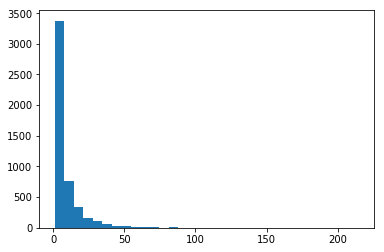

In [37]:
n_strata = 32
_ = plt.hist(df_influencer.node_2, bins=n_strata)
strata_size, strata_bound = _[0], _[1]

In [38]:
strata_sizes = list(map(round, strata_size))
strata_bounds = list(map(round, strata_bound))

In [39]:
seeds = []
for i in range(n_strata):
    l, r = strata_bounds[i], strata_bounds[i + 1]
    strata_size = int(strata_sizes[i])
    df_strata = df_influencer[(df_influencer.node_2 > l) & (df_influencer.node_2 < r)]
    cluster_n_seeds = round(n_seeds * strata_size / len(df_influencer))
    cluster_seeds = list(df_strata[:cluster_n_seeds].index.values)
    print("influence %i ~ %i, cluster size %i, seeds %i"
          %(l, r, strata_size, len(cluster_seeds)))
    
    seeds += cluster_seeds
print(len(seeds))

influence 1 ~ 8, cluster size 3377, seeds 41
influence 8 ~ 14, cluster size 763, seeds 9
influence 14 ~ 21, cluster size 333, seeds 4
influence 21 ~ 28, cluster size 159, seeds 2
influence 28 ~ 34, cluster size 115, seeds 1
influence 34 ~ 41, cluster size 61, seeds 1
influence 41 ~ 48, cluster size 34, seeds 0
influence 48 ~ 54, cluster size 30, seeds 0
influence 54 ~ 61, cluster size 10, seeds 0
influence 61 ~ 68, cluster size 12, seeds 0
influence 68 ~ 75, cluster size 10, seeds 0
influence 75 ~ 81, cluster size 4, seeds 0
influence 81 ~ 88, cluster size 6, seeds 0
influence 88 ~ 95, cluster size 2, seeds 0
influence 95 ~ 101, cluster size 1, seeds 0
influence 101 ~ 108, cluster size 2, seeds 0
influence 108 ~ 115, cluster size 3, seeds 0
influence 115 ~ 121, cluster size 1, seeds 0
influence 121 ~ 128, cluster size 1, seeds 0
influence 128 ~ 135, cluster size 0, seeds 0
influence 135 ~ 141, cluster size 3, seeds 0
influence 141 ~ 148, cluster size 2, seeds 0
influence 148 ~ 155, clu

In [40]:
evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
13,5,552,0.905797
12,5,537,0.931099
19,10,437,2.288330
8,3,377,0.795756
10,4,375,1.066667
2,3,359,0.835655
4,5,357,1.400560
11,2,330,0.606061
1,2,319,0.626959
